In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
from torchvision import models
from torchvision import datasets, transforms
from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import re
from collections import Counter

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords

> Retrieve the song data from the file provided

In [2]:
songs_df = pd.read_csv('Songs.csv', header = 0)
songs_df.head(5)

,Artist,Title,Lyrics
0,Taylor Swift,cardigan,"Vintage tee, brand new phone\nHigh heels on co..."
1,Taylor Swift,exile,"I can see you standing, honey\nWith his arms a..."
2,Taylor Swift,Lover,We could leave the Christmas lights up 'til Ja...
3,Taylor Swift,the 1,"I'm doing good, I'm on some new shit\nBeen say..."
4,Taylor Swift,Look What You Made Me Do,I don't like your little games\nDon't like you...


> Each entry ends with something like '1EmbedShare URLCopyEmbedCopy', so we removed those appearances from the lyrics.

In [3]:
songs_df['Lyrics'] = songs_df['Lyrics'].str.replace(r'\d+EmbedShare URLCopyEmbedCopy$', "", regex=True)

> Show all unique artists in the dataset

In [4]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 30 Songs
​twenty one pilots: 30 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 30 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> The dataset's size.

In [5]:
print(f'The dataset contains {len(songs_df)} entries for songs.')

The dataset contains 745 entries for songs.


> The dataset contains 3 duplicates so we will need to take care of that.

In [6]:
print(f'The dataset contains {len(songs_df['Title'].unique())} unique songs.')

The dataset contains 742 unique songs.


> Cleanup of duplicates

In [7]:
songs_df = songs_df.drop_duplicates(subset='Title')

In [8]:
for artist in songs_df['Artist'].unique():
    print(f'{artist}: {songs_df[songs_df['Artist'] == artist].shape[0]} Songs')

Taylor Swift: 50 Songs
Billie Eilish: 50 Songs
The Beatles: 35 Songs
David Bowie: 50 Songs
Billy Joel: 50 Songs
Ed Sheeran: 20 Songs
Eric Clapton: 50 Songs
Bruce Springsteen: 40 Songs
Vance Joy: 30 Songs
Lana Del Rey: 30 Songs
Bryan Adams: 30 Songs
Leonard Cohen: 50 Songs
Nat King Cole: 29 Songs
​twenty one pilots: 29 Songs
Ray LaMontagne: 30 Songs
Bob Dylan: 20 Songs
John Denver: 30 Songs
Frank Sinatra: 29 Songs
Queen: 30 Songs
Elton John: 30 Songs
George Michael: 30 Songs


> Average song length

In [9]:
lengths = songs_df['Lyrics'].apply(lambda x: len(x.split()))
avg_words = lengths.sum() / songs_df['Lyrics'].nunique()

char_lengths = songs_df['Lyrics'].apply(lambda x: len(x))
avg_chars = char_lengths.sum() / songs_df['Lyrics'].nunique()

print(f'The average number of words in a song is {avg_words:.2f}')
print(f'The average number of characters in a song is {avg_chars:.2f}')

The average number of words in a song is 275.94
The average number of characters in a song is 1388.24


> Word Cloud

The 3 most common words are:
the: 8124 appearances
you: 7105 appearances
i: 6872 appearances


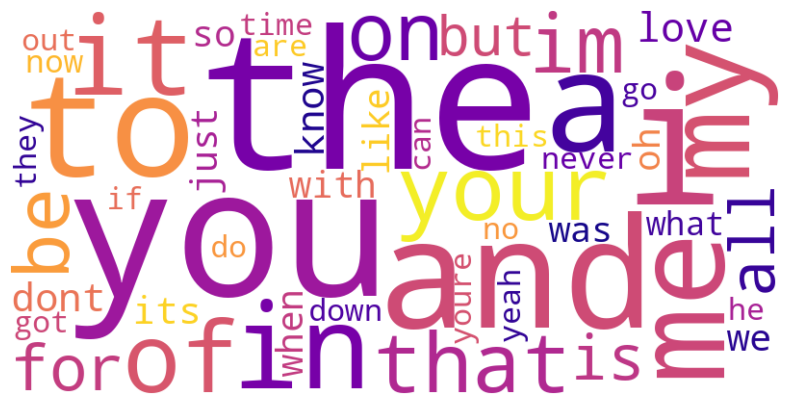

In [10]:
# Combine all lyrics into one large text
all_lyrics = " ".join(songs_df["Lyrics"].dropna())

# Clean the text (remove punctuation, convert to lowercase)
all_lyrics = re.sub(r"[^\w\s]", "", all_lyrics.lower())

# Tokenization
words = all_lyrics.split()

# Retrieve word frequencies
word_counts = Counter(words)

# 3 most common words
print("The 3 most common words are:")
for word, count in word_counts.most_common(3):
    print(f"{word}: {count} appearances")

# Definition of wordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap='plasma', max_words=50).generate_from_frequencies(word_counts)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
lyrics = songs_df["Lyrics"].dropna().str.lower()

# Tokenization the lyrics removing puncuation
tokenized_lyrics = [re.findall(r"\b\w+\b|\n", lyric) for lyric in lyrics]

# Build vocabulary
word_counts = Counter(word for song in tokenized_lyrics for word in song)
word_to_index = {word: i + 1 for i, (word, _) in enumerate(word_counts.items())}  # Start index from 1
index_to_word = {i: word for word, i in word_to_index.items()}

# Convert lyrics to numerical sequences
encoded_sequences = [[word_to_index[word] for word in song if word in word_to_index] for song in tokenized_lyrics]

# Vocabulary size
vocab_size = len(word_to_index) + 1  # Adding 1 for padding if needed

print(f"Vocabulary Size: {vocab_size}")

Vocabulary Size: 9071


In [12]:
# Set sequence length (choose a reasonable length)
SEQ_LENGTH = 15

# Create input-target pairs
input_sequences = []
targets = []

for song in encoded_sequences:
    for i in range(1, len(song)):
        n_gram_sequence = song[:i+1]  # Create sequence up to current word
        if len(n_gram_sequence) >= 2:  # Ensure sequence has at least one input and one target
            input_sequences.append(n_gram_sequence[:-1])  # All but last word (input)
            targets.append(n_gram_sequence[-1])  # Last word (target)

# Pad sequences to the same length
max_seq_length = SEQ_LENGTH  # Set fixed sequence length
padded_sequences = [([0] * (max_seq_length - len(seq)) + seq)[-max_seq_length:] for seq in input_sequences]

# Convert to tensors
X = torch.tensor(padded_sequences, dtype=torch.long)
y = torch.tensor(targets, dtype=torch.long)

# PyTorch Dataset
class SongLyricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create DataLoader
dataset = SongLyricsDataset(X, y)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Dataset Size: {len(dataset)}")

Dataset Size: 251112


In [13]:
class LyricsLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=256, num_layers=4):
        super(LyricsLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)  # Convert word indices to embeddings
        lstm_out, _ = self.lstm(x)  # LSTM forward pass
        out = self.fc(lstm_out[:, -1, :])  # Get output from last LSTM step
        return out

# Model setup
model = LyricsLSTM(vocab_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LyricsLSTM(
  (embedding): Embedding(9071, 256)
  (lstm): LSTM(256, 256, num_layers=4, batch_first=True)
  (fc): Linear(in_features=256, out_features=9071, bias=True)
)

> Train for 100 Epochs as requested

In [14]:
EPOCHS = 25

train_losses = []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch_X, batch_y in data_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    train_losses.append(avg_loss)  # Save the average loss for this epoch
    if epoch%5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(data_loader):.4f}")


Epoch 1/25, Loss: 5.5584
Epoch 11/25, Loss: 2.1636
Epoch 21/25, Loss: 1.2022


> Plot the training loss

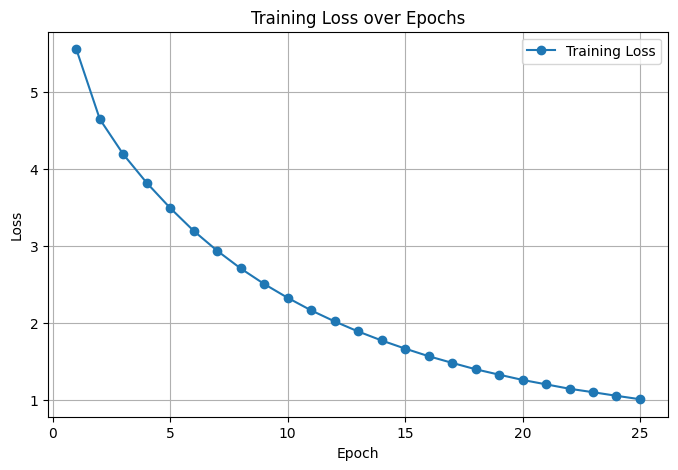

In [15]:
# Plotting the training loss after training completes
plt.figure(figsize=(8, 5))
plt.plot(range(1, EPOCHS + 1), train_losses, marker='o', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
def LyricsGenerator(starting_string, model, word_to_index, index_to_word, max_words=avg_words):
    model.eval()
    max_words = int(max_words)
    
    if not starting_string.strip():
        starting_word = random.choice(list(word_to_index.keys()))
        words = [starting_word]
    else:
        words = starting_string.lower().split()
    
    for _ in range(max_words):
        # Convert words to indices
        encoded_input = [word_to_index.get(word, 0) for word in words][-SEQ_LENGTH:]
        input_tensor = torch.tensor([encoded_input], dtype=torch.long).to(device)

        # Predict next word
        with torch.no_grad():
            output = model(input_tensor)
            predicted_index = torch.argmax(output, dim=1).item()

        # Convert index to word
        next_word = index_to_word.get(predicted_index, "<UNK>")
        words.append(next_word)

    return " ".join(words)


In [17]:
seed = "it's not a silly little moment"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word)
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 it's not a silly little moment but we ll be together 
 wherever you out of my mind 
 why should i worry 
 why should i say where i say 
 it s all i ve been 
 i ve been putting out the fire 
 traveling light most a balcony 
 i ve been tearing into a woman so stick away 
 but if i m down in a paper bag 
 joyful their course of relief 
 if i could fly at the morning dance 
 but i can see my sweet boy 
 me he tried to read the rules 
 of a brief deck 
 the greatest happiness he ain t worth all 
 for the things that he don t care 
 
 but i know you re gonna kill you 
 but you just have to just a white family good end down uh 
 hot golden days in my hair it holds his loving to mine 
 i will be loving you for a woman 
 if you need me can t be bad 
 if you need me wanna see me 
 let me wanna be 
 let it be your woman 
 be there for you will never be 
 ah baby won t you say i can only tell you 
 there s no need to do in spite 
 i don t wanna know about your new man 
 cause i

In [18]:
seed = "There is a house"
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word)
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 there is a house 
 and soon i m offering it all 
 i ve been putting out the fire 
 somehow 
 
 so i m leaving out fire 
 
 sometimes i got street somewhere of popping 
 i believe that you came in me 
 but i don t like why 
 and when i m sinking from yesterday 
 makes me feel important 
 i ve been tested too far 
 i ve been the bad old boy 
 
 i ve been the bad guy who did 
 no one she knows it s all 
 and there s no way on night 
 and for rides 
 as soon a smile who knows him any time 
 and when she wants to know 
 that she wants her apart 
 
 she sends her then she s never mess 
 she s got a perfect hallelujah 
 how many times have a man 
 but i ll be here doc a lady 
 or i ll be holding on to you 
 and i know that i ll never say this 
 hey believe the waitress i ll give for you to me 
 i ll go with you to myself 
 you ll see me in my arms 
 you would give your woman on your face 
 and now i m going back again 
 and if i was just a man 
 or anything what is when yo

In [19]:
seed = ""
generated_text = LyricsGenerator(seed, model, word_to_index, index_to_word)
print("\nGenerated Lyrics:\n", generated_text)


Generated Lyrics:
 head got got like i was a lit of man 
 i was the entertainer 
 and i m trusting the laws 
 of no sound i m gonna shoot the dog 
 and another promise we ll keep from our feet on two 
 they will be there 
 we d be there 
 then we ll run and die 
 and they say we go with it 
 but together that lives so cold 
 and some say it s here 
 and you know that it s only you you can 
 and i ve been waiting 
 
 take this i m still 
 saved in my heart without you 
 think of this sacred club 
 i ve been tested for a little while 
 said i was in the autumn with a week 
 of leather my own 
 and we had a lot of signs 
 that they spend their broken souls 
 and we came to sound 
 she d sits forever 
 well she says casey it keeps come down 
 she thinks i saw her heaven who cried so right 
 and i don t know where to be 
 when you re looking with me inside 
 
 baby baby everything is goin on 
 you re alone with me baby 
 we re going home 
 but baby baby baby we were waiting 
 we ll be fine